In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog
import customtkinter as ctk
from PIL import ImageTk, Image
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from wordcloud import WordCloud
import cv2
import warnings
warnings.filterwarnings('ignore')

#------------------------------------------------------------------#

def processData(data): 

    data = data.drop(axis = 1, columns = ['Unnamed: 0'])
    data['Title'] = data['Title'].fillna("")
    data['Review Text'] = data['Title'] + " " + data['Review Text']
    data = data.drop(axis = 1, columns = ['Title'])
    data.dropna(inplace = True)
    to_remove = ["Clothing ID","Division Name"]
    data = data.drop(axis = 1, columns = to_remove)

    #Tokeniation
    from nltk.tokenize import word_tokenize
    def tokenize(column):
        tokens = nltk.word_tokenize(column)
        return [w for w in tokens if w.isalpha()]  
    data['tokenized'] = data.apply(lambda x: tokenize(x['Review Text']), axis=1)
    
    #Remove Stop words
    from nltk.corpus import stopwords
    def remove_stopwords(tokenized_col):
        stop = set(stopwords.words("english"))
        return [word for word in tokenized_col if not word in stop]
    data['Tokenized_No(S.W)'] = data.apply(lambda x: remove_stopwords(x['tokenized']), axis=1)

    #Stemming
    from nltk.stem import PorterStemmer
    def stemming(tokenized_col):
        stemmer = PorterStemmer() 
        return [stemmer.stem(word) for word in tokenized_col]
    data['Tokenized__stemmed'] = data.apply(lambda x: stemming(x['Tokenized_No(S.W)']), axis=1)

    #Rejoin Words
    def rejoin(tokenized_column):
        return ( " ".join(tokenized_column))
    data['Clean Review'] = data.apply(lambda x: rejoin(x['Tokenized__stemmed']), axis=1)

    #Remove old columns
    to_remove = ["Review Text","tokenized","Tokenized_No(S.W)","Tokenized__stemmed"]
    data = data.drop(axis = 1, columns = to_remove)

    return data

In [18]:
def doEDA(self):
    file = self.file_path.get()
    data=pd.read_csv(file)
    #data = processData(data)
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#00CDAC', '#FF60A8', '#FFDACC', '#FF6F68', '#CFF800'])
    plt.rcParams.update({'text.color' : "#ECF7DD", 'axes.labelcolor' : "ECF7DD" , 'xtick.color' : "ECF7DD" , 'ytick.color' : "ECF7DD"})
    #Fig1
    fig1 , ax1 = plt.subplots()
    fig1.set_facecolor('#050A30')
    f1 = sns.countplot(x = 'Department Name' , hue = 'Rating' , data = data);
    ax1.set_title("Rating counts per Department")
    ax1.set_facecolor('#050A30')
    #plt.show()

    #Fig 2
    fig2 , ax2 = plt.subplots()
    fig2.set_facecolor('#050A30')

    f2 = sns.countplot(x = 'Department Name' , hue = 'Recommended IND' , data = data);
    ax2.set_title("Most Recommended Depart among customrs")
    ax2.set_facecolor('#050A30')
    #plt.show()

    #Fig 3
    fig3 , ax3 = plt.subplots()
    fig3.set_facecolor('#050A30')
    value_counts = data['Rating'].value_counts()
    plt.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%' )
    ax3.set_title("Ratings Percentages")
    ax3.set_facecolor('#050A30')

    #plt.show()

    #Fig 4 
    count_vectorizer = CountVectorizer(ngram_range=(1, 2),stop_words='english', lowercase=True , max_df = 0.6 , max_features=1000)
    cv_data = count_vectorizer.fit_transform(data['Clean Review'])
    f_wordcloud = count_vectorizer.get_feature_names_out()
    f_wordcloud_str = ' '.join(f_wordcloud)
    wordcloud = WordCloud(width=800, height=400, background_color ='#050A30', min_font_size = 7).generate(f_wordcloud_str)
    fig4 , ax4 = plt.subplots()
    ax4.set_facecolor('#D3D3D3')

    plt.imshow(wordcloud)
    ax4.set_title("Trends in Reviews")
    plt.axis("off")
    plt.tight_layout(pad=0)
    #plt.show()
    plots = [fig1,fig2,fig3,fig4]
    return plots

In [19]:
from tkinter import ttk
from tkinter import *
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

def viewEDA(plots, self):
    # Create a new style for the notebook
    style = ttk.Style()
    style.theme_create('notebook_style', parent='alt', settings={
        'TNotebook.Tab': {
        'configure': {'padding': [10, 5], 'background': '#2494CC', 'foreground': '#0e0c40'},
        'map': {'background': [('selected', '#F1C0B9')], 'foreground': [('selected', 'black')]}
        }
    })
    style.theme_use('notebook_style')

    # Create the notebook widget
    self.notebook = ttk.Notebook(self.insight_frame, width=600, height=600)

    # Add the plots to the notebook
    for i, fig in enumerate(plots, start=1):
        canvas = FigureCanvasTkAgg(fig, master=self.notebook)
        canvas.draw()
        self.notebook.add(canvas.get_tk_widget(), text=f"Plot {i}")

    self.notebook.grid(row=0, column=0,pady=(55,10)) 
    #^ Back Button
    self.BackButton = ctk.CTkButton(self.insight_frame, text="Back", text_color='#050A30', command=self.Back,width=100,fg_color="#FFFF00" ,hover_color='#05445E')
    self.BackButton.grid(row=1, column=0, pady=0) 

    self.notebook.enable_traversal()

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sentimentAnalyzer(self):    
    #^ Intro Text
    self.Intro_text = ctk.CTkLabel(self.sentiment_frame, text="Sentiment Analysis",font=ctk.CTkFont(size=20, weight="bold"),text_color='white')
    self.Intro_text.grid(row=0, column=0, padx=30, pady=(15, 15))
    #^ User Input
    self.sentence = ctk.CTkTextbox(self.sentiment_frame, width=200)
    self.sentence.grid(row=1, column=0, padx=30, pady=(15, 15)) 
    #^ Analyze Button
    self.AnalyzeButton = ctk.CTkButton(self.sentiment_frame, text="Analyze", text_color='#050A30', command=self.Analyze,width=100,fg_color="#FFFF00" ,hover_color='#05445E')
    self.AnalyzeButton.grid(row=2, column=0, padx=30, pady=(15, 15)) 
    #^ Result intro Text
    self.Intro_text = ctk.CTkLabel(self.sentiment_frame, text="Your review result..",font=ctk.CTkFont(size=20, weight="bold"),text_color='white')
    self.Intro_text.grid(row=3, column=0, padx=30, pady=(40, 15))
    #^ Result 
    self.resultField = ctk.CTkEntry(self.sentiment_frame, width=200)
    self.resultField.grid(row=4, column=0, padx=30, pady=(15, 15)) 
    #^ Clear Button
    self.ClearButton = ctk.CTkButton(self.sentiment_frame, text="Clear", text_color='#050A30', command=self.clearAll,width=100,fg_color="#FFFF00" ,hover_color='#05445E')
    self.ClearButton.grid(row=5, column=0, padx=30, pady=(15)) 
    #^ Back Button
    self.BackButton = ctk.CTkButton(self.sentiment_frame, text="Back", text_color='#050A30', command=self.Back,width=100,fg_color="#FFFF00" ,hover_color='#05445E')
    self.BackButton.grid(row=6, column=0, padx=30, pady=(15)) 


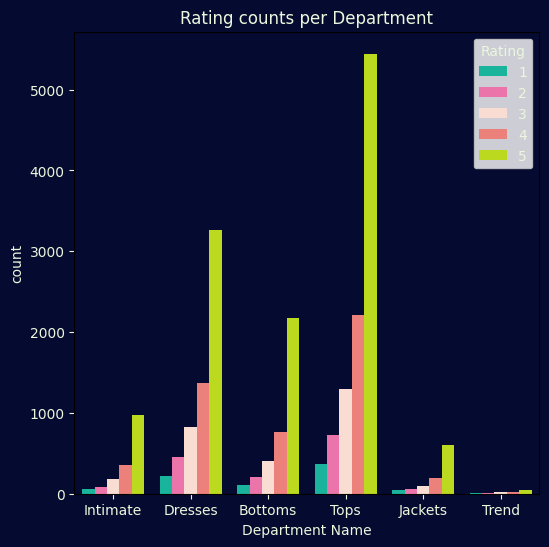

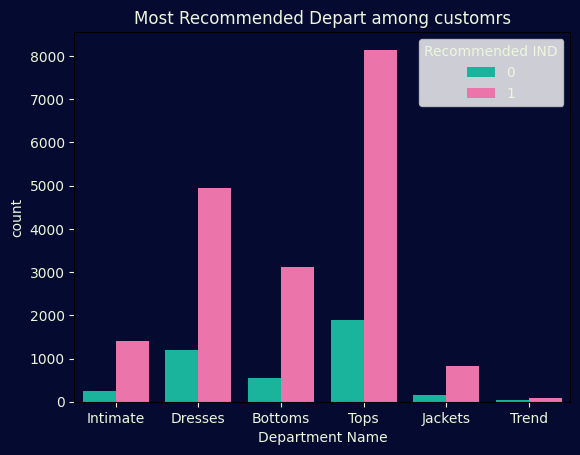

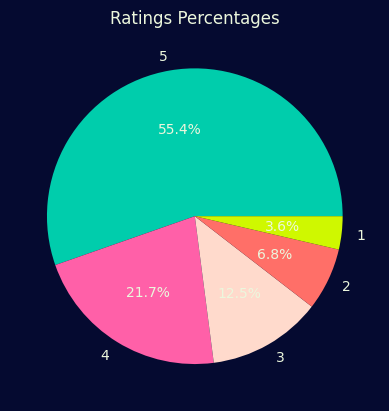

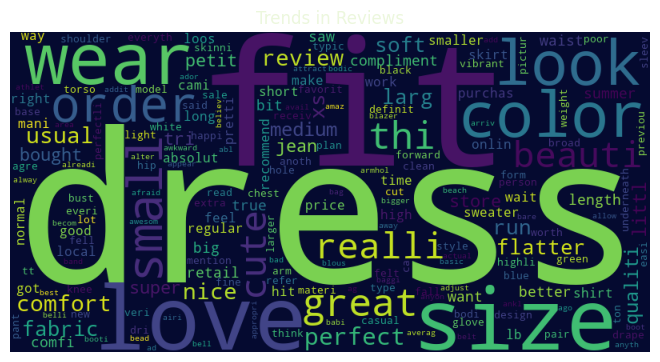

In [21]:
from PIL import Image
class GUI(ctk.CTk):

    #^ Main Functions 
    def __init__(self):
        super().__init__()

        #! Appearance
        ctk.set_appearance_mode("dark")
        ctk.set_default_color_theme("blue") 

        #! General Attributes
        self.title("M.V.B Project")
        self.iconbitmap("Assets//ic.ico")
        self.geometry('1000x600')
        self.resizable(False, False)
        self.bg_image = ctk.CTkImage(Image.open("Assets//my_bg.jpg"),size=(1000, 600))
        self.logo_image = ctk.CTkImage(Image.open("Assets//picture.png"),size=(120,120))
        self.file_path = ctk.StringVar(self)
        self.checkbox_var = tk.BooleanVar(value=True)

        #! Background
        self.bg_image_label = ctk.CTkLabel(self, image=self.bg_image)
        self.bg_image_label.grid(row=0, column=0)

        #! Home Frame = Foreground
        self.home_frame = ctk.CTkFrame(self, corner_radius=45,bg_color="#2EFF2E" , fg_color='#050A30')
        self.home_frame.grid(row=0, column=0, sticky="ns")

        #? Intro Text 
        self.Intro_text = ctk.CTkLabel(self.home_frame, text="Business Insights App",font=ctk.CTkFont(size=20, weight="bold"),text_color='white')
        self.Intro_text.grid(row=0, column=0, padx=30, pady=(60, 15))

        #? Upload Area 
        self.path = ctk.CTkEntry(self.home_frame, placeholder_text="path" ,textvariable=self.file_path)
        self.path.grid(row=1, column=0, pady=(15, 15))

        self.upload_button = ctk.CTkButton(self.home_frame, text="upload", text_color='#050A30', command=self.upload_file,width=100,fg_color="#2EFF2E" ,hover_color='#05445E')
        self.upload_button.grid(row=2, column=0 ,pady=(15, 15))

        #? Do EDA Button
        self.insight_CTkButton = ctk.CTkButton(self.home_frame, text="Extract Insights", text_color='#050A30', command=self.eda , width=200 ,fg_color="#2EFF2E" ,hover_color='#05445E' )
        self.insight_CTkButton.grid(row=3, column=0, padx=5, pady=(15, 15))

        #? Sentiment Analysis Button 
        self.sentiment_CTkButton = ctk.CTkButton(self.home_frame, text="Sentiment Analysis page", text_color='#050A30', command=self.show_sentiment_page, width=200 ,fg_color="#2EFF2E" ,hover_color='#05445E')
        self.sentiment_CTkButton.grid(row=4, column=0, padx=5, pady=(15, 15))

        #? Logo Photo
        self.logo_image_label = ctk.CTkLabel(self.home_frame, image=self.logo_image , text="M.V.B")
        self.logo_image_label.grid(row=7, column=0, padx=5, pady=(15, 15))

        #! Insights Frame
        self.insight_frame = ctk.CTkFrame(self, corner_radius=45,width=900,bg_color="#FF0080" , fg_color='#050A30')  
        #! Sentiment Frame
        self.sentiment_frame = ctk.CTkFrame(self, corner_radius=45,bg_color="#FFFF00" , fg_color='#050A30')  

    def show_insight_page(self):
        self.home_frame.grid_forget()
        self.insight_frame.grid(row=0, column=0, sticky="ns")
        viewEDA(plots , self)

    def show_sentiment_page(self):
        self.home_frame.grid_forget()
        self.sentiment_frame.grid(row=0, column=0, sticky="ns")
        sentimentAnalyzer(self)

    #^ Helper Functions
    def upload_file(self):
        self.file_path.set(filedialog.askopenfilename())

    def eda(self):
        global plots
        plots = doEDA(self)
        #? View result Button when Results are ready
        self.show_insight_CTkButton = ctk.CTkButton(self.home_frame, text="View Insights", text_color='#050A30', command=self.show_insight_page , width=200 ,fg_color="#2EFF2E" ,hover_color='#05445E')
        self.show_insight_CTkButton.grid(row=5, column=0, padx=5, pady=(15, 15))
        #? Check Box 
        self.chk = ctk.CTkCheckBox(self.home_frame, text="Results Ready", variable=self.checkbox_var , fg_color='#FF0080')
        self.chk.grid(row=6, column=0, padx=5, pady=(15, 15))

    def Analyze(self):
        
        # Create a SentimentIntensityAnalyzer object.
        sid_obj = SentimentIntensityAnalyzer()
        sentiment_dict = sid_obj.polarity_scores(self.sentence.get("1.0", "end"))

        if sentiment_dict['compound'] >= 0.05 :
            string = "Review is Positive"
    
        elif sentiment_dict['compound'] <= - 0.05 :
            string = "Review is Negative"
        
        else :
            string = "Review is Neutral"
    
        self.resultField.insert(10, string)

    def clearAll(self):
        self.resultField.delete(0, END)
        self.sentence.delete(1.0, END)
        
    def Back(self):
        self.insight_frame.grid_forget()
        self.sentiment_frame.grid_forget()
        self.home_frame.grid(row=0, column=0, sticky="ns")


# Create an instance of the app and run it
app = GUI()
app.mainloop()